In [90]:
#!c1.32
# импортируем модули

import os
import re
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
# Sequential - модель нейронной сети, в которой слои идут друг за другом
from keras.models import Sequential 
# Тип слоев Dense означает, что слои будут полносвязными
from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D
# ImageDataGenerator для чтения с диска и подготовки изображений
from keras.preprocessing.image import ImageDataGenerator

In [27]:
# %pip install requests urllib if needed

import requests
from urllib.parse import urlencode
from io import BytesIO
from zipfile import ZipFile

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/TvlN8KDiWCHvVw'

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
response = requests.get(download_url)

dist_path = 'data'
zipfile = ZipFile(BytesIO(response.content))
zipfile.extractall(path=dist_path)


In [120]:
#!c1.32
# классы изображений

translate = {
    "cane": "собака", 
    "cavallo": "лошадь", 
    "elefante": "слон", 
    "farfalla": "бабочка", 
    "gallina": "курица", 
    "gatto": "кошка", 
    "mucca": "корова", 
    "pecora": "овца", 
    "scoiattolo": "белка",
    "ragno": "паук"
}

categories = ["cane", "cavallo", "elefante", "farfalla", "gallina", "gatto", "mucca", "pecora", "scoiattolo", "ragno"]

In [32]:
# смотрим сколько исходных данных в каждом классе
# создаем каталоги для тестовых данных

train_data_dir = './data/train_data'
test_data_dir = './data/test_data'
train_data = {}
total_train_data = 0
for folder in os.listdir(train_data_dir):
    i = 0
    currentFolder = os.path.join(train_data_dir, folder)
    if os.path.isdir(currentFolder):
        for file in os.listdir(currentFolder):
            i += 1
        train_data[folder] = i
        os.mkdir(os.path.join(test_data_dir, folder))
print('Тренировочных данных по классам:')
for data in train_data.items():
    total_train_data += data[1]
    print(translate[data[0]] + ':', data[1])

Тренировочных данных по классам:
собака: 4863
лошадь: 2623
слон: 1446
бабочка: 2112
курица: 3098
кошка: 1668
корова: 1866
овца: 1820
паук: 4200
белка: 1862


In [33]:
# переносим 30% тренировочных данных в тестовые наборы

test_data = {}
total_test_data = 0
for folder in os.listdir(train_data_dir):
    currentFolder = os.path.join(train_data_dir, folder)
    if os.path.isdir(currentFolder):
        filesList = os.listdir(currentFolder)
        part = round((train_data[folder] / 100) * 30)
        test_data[translate[folder]] = part
        for i in range(1, part):
            shutil.copy(os.path.join(currentFolder, filesList[i]), os.path.join(test_data_dir, folder, filesList[i]))
print('Тестовых данных по классам:')
for data in test_data.items():
    total_test_data += data[1]
    print(data[0] + ':', data[1])

Тестовых данных по классам:
собака: 1459
лошадь: 787
слон: 434
бабочка: 634
курица: 929
кошка: 500
корова: 560
овца: 546
паук: 1260
белка: 559


In [113]:
#!c1.32
# преобразуем изображения к тензорам с плавающей запятой
# декодируем изображения и преобразуем в нужный формат с учетом RGB-профиля
# нормализуем значения тензора из интервала от 0 до 255 к интервалу от 0 до 1

BATCH_SIZE = 32 # количество тренировочных изображений для обработки перед обновлением параметров модели
IMG_SHAPE = 150 # размерность к которой будет приведено входное изображение

train_data_dir = './data/train_data'
test_data_dir = './data/test_data'

image_generator = ImageDataGenerator(rescale=1./255)

# directory - путь к каталогу с данными (каждый класс должен находиться в своем каталоге)
# если не передан массив с именами классов, они определеятся на основании наименований каталогов
# class_mode - тип возвращаемых меток (categorical - двухмерные одноразовые кодированные метки)
# от выбора class_mode зависит выбор функции потерь
# batch_size - размер пакетов данных
# target_size - размер, к которому должно быть приведено изображение

train_data_gen = image_generator.flow_from_directory(directory=train_data_dir,
                                                     class_mode='categorical',
                                                     batch_size=BATCH_SIZE,
                                                     target_size=(IMG_SHAPE, IMG_SHAPE),
                                                     classes=translate.keys())

test_data_gen = image_generator.flow_from_directory(directory=test_data_dir,
                                                    class_mode='categorical',
                                                    batch_size=BATCH_SIZE,
                                                    target_size=(IMG_SHAPE, IMG_SHAPE),
                                                    classes=translate.keys())

Found 25558 images belonging to 10 classes.
Found 7658 images belonging to 10 classes.


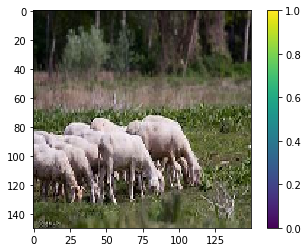

In [97]:
#!c1.32
# посмотрим, как выглядит изображение
# получим кортеж изображений с помощью функции matplotlib next

sample_training_images, _ = next(train_data_gen)
plt.figure()
plt.imshow(sample_training_images[0])
plt.colorbar()
plt.grid(False)

# на шкале справа отображается интенсивность пикселей

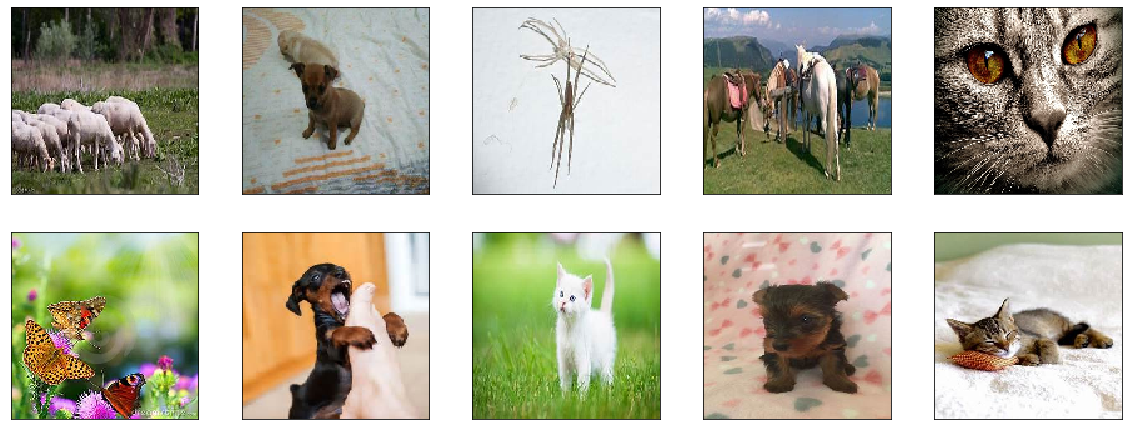

In [98]:
#!c1.32
# выведем сразу несколько изображений

plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(sample_training_images[i])

In [99]:
#!c1.32
# создаем модель нейронной сети
# в качестве аргумента передается массив слоев, которые будут обрабатываться последовательно
# в модели 4 сверточных слоя, в которых данные 

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)), # слой 2D свертки (например, пространственная свертка над изображениями)
    MaxPooling2D(2, 2), # операция максимальной подвыборки(субдискретизации) для пространственных данных
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'), # входной полносвязный слой (здесь определяется количество нейронов, которые будут в этом слое)
    Dense(10, activation='softmax') # выходной полносвязный слой (количество нейронов равно количеству классов)
])
# функция активации softmax возвращает вероятность принадлежности изображения к одному из классов

In [100]:
#!c1.32
# компиляция модели
# optimizer - оптимизатор, используем стохастический градиентный спуск SGD, можно также использовать оптимизатор adam
# loss - функция ошибки
# категориальная перекрестная энтропия categorical_crossentropy предпочтительна когда классов больше двух
# metrics - параметр качества, используем accuracy (доля правильных ответов)

model.compile(optimizer=keras.optimizers.SGD(), loss='categorical_crossentropy', metrics=['accuracy'])

In [101]:
#!c1.32
# выведем параметры модели

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)      

In [102]:
#!c1.32
# обучение модели
# epochs - количество эпох
# steps_per_epoch - количество шагов для выхода из генератора для завершения одной эпохи и начала следующей (вычисляется по формуле)
# validation_steps - общее количество шагов (партий сэмплов) для получения данных из генератора до остановки в конце каждой эпохи

model.fit(
    train_data_gen, 
    epochs=10, 
    validation_data=test_data_gen
)

799/799 [==============================] - 135s 169ms/step - loss: 1.6369 - accuracy: 0.4350 - val_loss: 1.5102 - val_accuracy: 0.4813
Epoch 4/10
799/799 [==============================] - 137s 171ms/step - loss: 1.4855 - accuracy: 0.4932 - val_loss: 1.3507 - val_accuracy: 0.5366
Epoch 5/10
799/799 [==============================] - 136s 170ms/step - loss: 1.3528 - accuracy: 0.5402 - val_loss: 1.2039 - val_accuracy: 0.6019
Epoch 6/10
799/799 [==============================] - 135s 169ms/step - loss: 1.2378 - accuracy: 0.5803 - val_loss: 1.1046 - val_accuracy: 0.6303
Epoch 7/10
799/799 [==============================] - 144s 180ms/step - loss: 1.1341 - accuracy: 0.6181 - val_loss: 1.0276 - val_accuracy: 0.6489
Epoch 8/10
799/799 [==============================] - 139s 174ms/step - loss: 1.0362 - accuracy: 0.6517 - val_loss: 0.8892 - val_accuracy: 0.7037
Epoch 9/10
799/799 [==============================] - 133s 166ms/step - loss: 0.9483 - accuracy: 0.6810 - val_loss: 0.8627 - val_accura

Результат предсказания:  паук вероятность:  0.9395169
На снимке:  паук


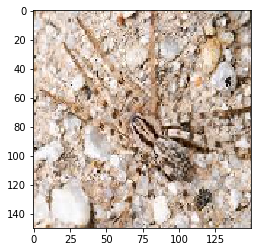

In [155]:
#!c1.32

# предсказание на изображениях из тестовой выборки
# посмотрим на изображение

index = 0
sample_val_images, lbl = next(test_data_gen)
plt.figure()
plt.imshow(sample_val_images[index])

# получим результат предсказания
predictions = model.predict(sample_val_images)
result = predictions[index]
print('Результат предсказания: ', translate[categories[np.argmax(result)]], 'вероятность: ', result[np.argmax(result)])
print('На снимке: ', translate[categories[lbl[index].tolist().index(1)]])

#print(np.argmax(result))